# Import Libraries

In [1]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import time
from sklearn.metrics import roc_auc_score

import re
import string
import nltk
import itertools
import numpy as np

# this allows you to apply a progress bar to pandas operations
from tqdm import tqdm
tqdm.pandas()

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Install Paddle OCR & OPENCV

In [2]:
# Github repo installation of paddle
!python -m pip install paddlepaddle -i https://mirror.baidu.com/pypi/simple
# Install paddle OCR
!pip install paddleocr
# git clone
!git clone https://github.com/PaddlePaddle/PaddleOCR.git
# cv2
!pip install "opencv-python-headless<4.3"


Looking in indexes: https://mirror.baidu.com/pypi/simple
fatal: destination path 'PaddleOCR' already exists and is not an empty directory.


# Import Libraries 2

In [3]:
import cv2
from paddleocr import PaddleOCR, draw_ocr
from matplotlib import pyplot as plt
import os

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/paddle/vision/transforms/functional_pil.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': Image.NEAREST,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/paddle/vision/transforms/functional_pil.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': Image.BILINEAR,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/paddle/vision/transforms/functional_pil.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': Image.BICUBIC,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/paddle/vision/transforms/functional_pil.py:39: DeprecationWarning: BOX is deprecated and will be removed in Pillo

# Define ocr_model = PaddleOCR. return text

In [4]:
ocr_model = PaddleOCR(lang='en')

[2022/09/26 12:39:52] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, shape_info_filename=None, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='/home/studio-lab-user/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='SVTR_LCNet', rec_model_dir='/home/studio-lab-user/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_shape='3, 48, 320', rec_bat

---    Fused 0 subgraphs into layer_norm op.
---    Fused 0 subgraphs into layer_norm op.


In [5]:
path_product_id = "/home/studio-lab-user/DS-Projects/OCR/Instax/"
%cd "{path_product_id}"

/home/studio-lab-user/DS-Projects/OCR/Instax


In [6]:
from glob import glob

pos_test_img_list = glob('pos*') # including 120 negative images
neg_test_img_list = glob('neg*')
print("number of positive images: " + str(len(pos_test_img_list)))
print("number of negative images: " + str(len(neg_test_img_list)))

number of positive images: 102
number of negative images: 216


In [7]:
import pandas as pd
df1 = pd.DataFrame()
df1['file_name'] = pos_test_img_list
df1['relevant'] = 1

df2 = pd.DataFrame()
df2['file_name'] = neg_test_img_list
df2['relevant'] = 0
df3 = pd.concat([df1,df2]).reset_index(drop=True)
df3

,file_name,relevant
0,pos (5).jpg,1
1,pos (6).jpg,1
2,pos (4).jpg,1
3,pos (7).jpg,1
4,pos (9).jpg,1
...,...,...
313,neg (300).jpg,0
314,neg (200).jpeg,0
315,neg (304).jpg,0
316,neg (302).jpg,0


# Define words & Scores output from Paadle OCR

In [8]:
def get_words_and_scores_and_add_to_dataframe(row):
    photo = row["file_name"]
    if photo == "empty":
        return [[],[]]
    image_path = f"/home/studio-lab-user/DS-Projects/OCR/Instax/{photo}"
    result = ocr_model.ocr(image_path)
    texts = [res[1][0] for res in result]
    scores = [res[1][1] *100 for res in result]
    result = [texts, scores]
    return result

# Apply(function, axis=1) to df3. GPU takes 0.1s, CPU takes 1s

In [9]:
df3["words"] = df3.apply(get_words_and_scores_and_add_to_dataframe, axis=1)

[2022/09/26 12:39:53] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2022/09/26 12:39:53] ppocr DEBUG: dt_boxes num : 2, elapse : 0.10837602615356445
[2022/09/26 12:39:53] ppocr DEBUG: rec_res num  : 2, elapse : 0.13704895973205566
[2022/09/26 12:39:53] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2022/09/26 12:39:53] ppocr DEBUG: dt_boxes num : 15, elapse : 0.058568716049194336
[2022/09/26 12:39:54] ppocr DEBUG: rec_res num  : 15, elapse : 0.9407572746276855
[2022/09/26 12:39:54] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2022/09/26 12:39:54] ppocr DEBUG: dt_boxes num : 1, elapse : 0.053989410400390625
[2022/09/26 12:39:54] ppocr DEBUG: rec_res num  : 1, elapse : 0.06450223922729492
[2022/09/26 12:39:54] ppocr WARNING: Since the angle class

In [10]:
len(df3)
df3.head()

,file_name,relevant,words
0,pos (5).jpg,1,"[[FUSFIEM, instax mini 40], [71.98682427406311..."
1,pos (6).jpg,1,"[[FUJ.FULM, mini, FUJMFILM, FUJ.FILM, mini, in..."
2,pos (4).jpg,1,"[[HoloK], [57.32165575027466]]"
3,pos (7).jpg,1,"[[FUJIFILM, instaxmini11], [93.03014278411865,..."
4,pos (9).jpg,1,"[[FUJ.FI, FUJIFILM, instax mini, MONO, CHROME,..."


In [11]:
def new_score_text(row):
    sample_list = row["words"][0]
    score_list = row["words"][1]
    new_text = []
    new_score = []
    for text, score in zip(sample_list, score_list): # assign text and score each
        new_text.extend(text.split()) #update new_text.
        number_of_space = text.count(" ") # number of spaces +1 is chunk of words
        for i in range(number_of_space+1):
            new_score.append(score)
            
    return [new_text, new_score]

In [12]:
df3["words"] = df3.apply(new_score_text, axis=1)

# Result of df3

In [13]:
df3.head(50)

,file_name,relevant,words
0,pos (5).jpg,1,"[[FUSFIEM, instax, mini, 40], [71.986824274063..."
1,pos (6).jpg,1,"[[FUJ.FULM, mini, FUJMFILM, FUJ.FILM, mini, in..."
2,pos (4).jpg,1,"[[HoloK], [57.32165575027466]]"
3,pos (7).jpg,1,"[[FUJIFILM, instaxmini11], [93.03014278411865,..."
4,pos (9).jpg,1,"[[FUJ.FI, FUJIFILM, instax, mini, MONO, CHROME..."
5,pos (10).jpg,1,"[[instax, minil1], [87.51217126846313, 87.5121..."
6,pos (13).jpg,1,"[[FUJIFILM, mini, FUJIFILM, instax, mini, BLUE..."
7,pos (8).jpg,1,"[[FUJ.FILM, instax, OX], [90.14217257499695, 9..."
8,pos (12).jpg,1,"[[instaxn.s, BOO], [80.72419166564941, 57.9865..."
9,pos (11).jpg,1,"[[instax, instax], [92.42021441459656, 99.3927..."


# Define cleaning_text. Make text lowercase and remove punctuations etc.
## Return is cleaned text and score into the list

In [14]:
import re
import string

def clean_text(row):
    word_list = row["words"][0]
    new_word_list = []
    for word in word_list:
        new_word = word.lower()
        new_word = re.sub("[%s]" % re.escape(string.punctuation), " ", new_word)
        new_word_list.append(new_word)
    return [new_word_list, row["words"][1]]

# Apply apply(function, axis=1)

In [15]:
df3["words"] = df3.apply(clean_text, axis=1)

# Result of Clean_text

In [16]:
df3.head(50)

,file_name,relevant,words
0,pos (5).jpg,1,"[[fusfiem, instax, mini, 40], [71.986824274063..."
1,pos (6).jpg,1,"[[fuj fulm, mini, fujmfilm, fuj film, mini, in..."
2,pos (4).jpg,1,"[[holok], [57.32165575027466]]"
3,pos (7).jpg,1,"[[fujifilm, instaxmini11], [93.03014278411865,..."
4,pos (9).jpg,1,"[[fuj fi, fujifilm, instax, mini, mono, chrome..."
5,pos (10).jpg,1,"[[instax, minil1], [87.51217126846313, 87.5121..."
6,pos (13).jpg,1,"[[fujifilm, mini, fujifilm, instax, mini, blue..."
7,pos (8).jpg,1,"[[fuj film, instax, ox], [90.14217257499695, 9..."
8,pos (12).jpg,1,"[[instaxn s, boo], [80.72419166564941, 57.9865..."
9,pos (11).jpg,1,"[[instax, instax], [92.42021441459656, 99.3927..."


# Targets

In [17]:
## define the target words / phrases
targets = ["instax", "fujifilm"]

# Get_final_score. each word from text is called sample.
1. calculate the edit_distance between target and sample 
2. calculate the closeness (how similar two words)
3. confidence_score_mean (don't know why confidence_score_mean. Can I use just confidencescore as a score?
4. final score = similarity * confidence score
5. If final score is higher than Max_score =0, max_score is replaced. The highest final score will be the max_score at the end

In [18]:
# helper functions for funal scoring function

def advance(iterator, step):
    next(itertools.islice(iterator, step, step), None)


def tuplewize(iterable, size):
    iterators = itertools.tee(iterable, size)
    for position, iterator in enumerate(iterators):
        advance(iterator, position)
    return zip(*iterators)

In [19]:
# define function to produce final scores

def get_final_score(row):
    sample_list = row["words"][0]
    score_list = row["words"][1]
    max_score = 0
    
    for target in targets:
        phrase_length = len(target.split())
        for i in range(1, phrase_length+1):
            for c, s in zip(tuplewize(sample_list, i), tuplewize(score_list, i)):
                new_sample = " ".join(c)
                edit_distance = nltk.edit_distance(target, new_sample)
                closeness = (len(target)-edit_distance)/len(target)
                confidence_score = np.mean(s)
                final_score = closeness * confidence_score
                if final_score > max_score:
                    max_score = final_score
             
    return max_score

# Calculate OCR_score which is Max_score from get_final_score function

In [20]:
df3["OCR_score"] = df3.apply(get_final_score, axis=1)
df3.head(50)

,file_name,relevant,words,OCR_score
0,pos (5).jpg,1,"[[fusfiem, instax, mini, 40], [71.986824274063...",94.177514
1,pos (6).jpg,1,"[[fuj fulm, mini, fujmfilm, fuj film, mini, in...",99.800974
2,pos (4).jpg,1,"[[holok], [57.32165575027466]]",0.000000
3,pos (7).jpg,1,"[[fujifilm, instaxmini11], [93.03014278411865,...",93.030143
4,pos (9).jpg,1,"[[fuj fi, fujifilm, instax, mini, mono, chrome...",98.494184
5,pos (10).jpg,1,"[[instax, minil1], [87.51217126846313, 87.5121...",87.512171
6,pos (13).jpg,1,"[[fujifilm, mini, fujifilm, instax, mini, blue...",97.374773
7,pos (8).jpg,1,"[[fuj film, instax, ox], [90.14217257499695, 9...",94.488120
8,pos (12).jpg,1,"[[instaxn s, boo], [80.72419166564941, 57.9865...",40.362096
9,pos (11).jpg,1,"[[instax, instax], [92.42021441459656, 99.3927...",99.392766


# display the dataframe sort by OCR_score

In [21]:
df3 = df3.sort_values(by='OCR_score', ascending=False)
pd.set_option('display.max_rows', None)
df3

,file_name,relevant,words,OCR_score
66,pos (72).jpg,1,"[[instax, mini8, fujifilm], [99.81348514556885...",99.813485
1,pos (6).jpg,1,"[[fuj fulm, mini, fujmfilm, fuj film, mini, in...",99.800974
42,pos (49).jpg,1,"[[umfilm, min, j film, mini, fujifilm, fujifil...",99.793679
65,pos (74).jpg,1,"[[instax, fujifilm, 60, instax mini, instant, ...",99.778503
87,pos (93).jpg,1,"[[furfim, funfilm, instax, instax, squar, squa...",99.759364
18,pos (18).jpg,1,"[[fujnfilm, fujifilm, instax, instax, mini, mi...",99.734288
27,pos (33).jpg,1,"[[instax, fujifilm, insto, nstaxm], [99.728041...",99.728042
83,pos (92).jpg,1,"[[fujifilm, fujifilm, instax, instax, mini, mi...",99.723476
99,pos (99).jpg,1,"[[instax, fujifilm, instax, mini, link], [99.7...",99.715978
24,pos (19).jpg,1,"[[instax, instax, instax, wie, wid], [99.68712...",99.705744


# ROCAUC score

In [22]:
RA_score = roc_auc_score(df3["relevant"], df3["OCR_score"])

print("Rekognition ROC AUC Score =  %.2f" % (RA_score))

Rekognition ROC AUC Score =  0.82


# Save the dataframe as a csv

In [23]:
df3.to_csv('/home/studio-lab-user/DS-Projects/OCR/Instax.csv')

In [24]:
# Dataframe of true positives

tp = df3.loc[(df3['relevant'] == 1) & (df3['OCR_score'] >= 50)] 
print(len(tp))

78


In [25]:
# Dataframe of true negatives

tn = df3.loc[(df3['relevant'] == 0) & (df3['OCR_score'] < 50)] 
print(len(tn))

216


In [26]:
# Dataframe of false positives

fp = df3.loc[(df3['relevant'] == 0) & (df3['OCR_score'] >= 50)] 
print(len(fp))

0


In [27]:
# Dataframe of false negatives

fn = df3.loc[(df3['relevant'] == 1) & (df3['OCR_score'] < 50)] 
print(len(fn))

24


In [28]:
# Precision (What % of irdentified positives and true?)
precision = len(tp) / (len(tp) + len(fp))
print(precision)

1.0


In [29]:
# PRecall (% of true positives identified)
recall = len(tp) / (len(tp) + len(fn))
print(recall)

0.7647058823529411


In [30]:
fn

,file_name,relevant,words,OCR_score
8,pos (12).jpg,1,"[[instaxn s, boo], [80.72419166564941, 57.9865...",40.362096
59,pos (56).jpg,1,"[[instaxidea, booklet], [96.46182656288147, 96...",32.153942
69,pos (79).jpg,1,"[[ofuuafin, suxeilm, instaxmini, 10], [51.2148...",30.924193
94,pos (82).jpg,1,"[[instaxmini, link], [81.45999908447266, 81.45...",27.153333
23,pos (26).jpg,1,"[[mini, nstantfilm, 20pcs, fit fuji, pat, mini...",24.946201
22,pos (29).jpg,1,"[[], []]",0.000000
19,pos (24).jpg,1,"[[], []]",0.000000
16,pos (25).jpg,1,"[[], []]",0.000000
13,pos (20).jpg,1,"[[], []]",0.000000
12,pos (17).jpg,1,"[[], []]",0.000000


# Visualisation

In [31]:
%cd /home/studio-lab-user/DS-Projects/OCR_Module/PaddleOCR

ocr_model = PaddleOCR(lang='en')

def extract_text(image_path):
    result = ocr_model.ocr(image_path)
    
    return [res[1][0] for res in result]

/home/studio-lab-user/DS-Projects/OCR_Module/PaddleOCR
[2022/09/26 12:42:56] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, shape_info_filename=None, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='/home/studio-lab-user/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='SVTR_LCNet', rec_model_dir='/home/studio-lab-user/.paddleocr/whl/rec/en/en_PP-

---    Fused 0 subgraphs into layer_norm op.
---    Fused 0 subgraphs into layer_norm op.


In [37]:
image_path = "/home/studio-lab-user/DS-Projects/OCR/Instax_rotate"
font_path = "/home/studio-lab-user/DS-Projects/OCR/PaddleOCR/doc/fonts/latin.ttf"

In [38]:
%cd /home/studio-lab-user/DS-Projects/OCR/PaddleOCR

/home/studio-lab-user/DS-Projects/OCR/PaddleOCR


In [39]:
def visualisation(image_path):
    result = ocr_model.ocr(image_path)
    boxes = [res[0] for res in result]
    texts = [res[1][0] for res in result]
    scores = [res[1][1] for res in result]
    img = cv2.imread(img_path) # import images
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # reorders the colour channels
    
    plt.figure(figsize=(15,15))
    annotated = draw_ocr(img, boxes, texts, scores)
    plt.imshow(annotated)

In [40]:
img_path = f'{image_path}/pos (50).jpg'
extract_text(img_path)
visualisation(img_path)

[2022/09/26 12:47:18] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process


FileNotFoundError: [Errno 2] No such file or directory: '/home/studio-lab-user/DS-Projects/OCR/Instax_rotate/pos (50).jpg'

[2022/09/26 12:52:37] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2022/09/26 12:52:37] ppocr DEBUG: dt_boxes num : 7, elapse : 0.05503582954406738
[2022/09/26 12:52:38] ppocr DEBUG: rec_res num  : 7, elapse : 0.4429011344909668
[2022/09/26 12:52:38] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2022/09/26 12:52:38] ppocr DEBUG: dt_boxes num : 7, elapse : 0.05420565605163574
[2022/09/26 12:52:38] ppocr DEBUG: rec_res num  : 7, elapse : 0.4469935894012451


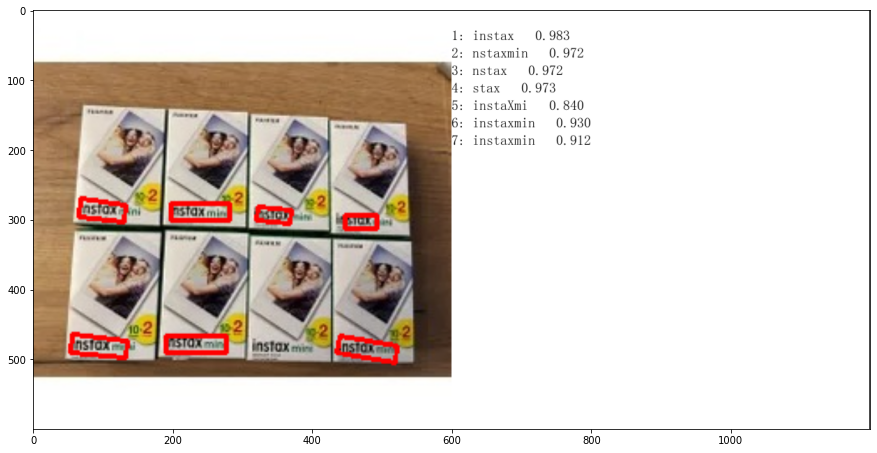

In [49]:
img_path = f'{image_path}/image.jpg'
extract_text(img_path)
visualisation(img_path)